Période couverte: de 2025-01-20 00:00:00 à 2025-02-18 00:00:00
Nombre total de jours de trading: 22

Performance de la stratégie Returns_MA:
Total Return: 5.21%
Annual Return: 83.87%
Sharpe Ratio: 4.69
Max Drawdown: -1.40%
Nombre de trades: 16
Win Rate: 50.00%

Performance de la stratégie Returns_RSI:
Total Return: 1.57%
Annual Return: 20.57%
Sharpe Ratio: 2.63
Max Drawdown: -0.94%
Nombre de trades: 9
Win Rate: 55.56%

Performance de la stratégie Returns_BB:
Total Return: -3.81%
Annual Return: -37.27%
Sharpe Ratio: -3.41
Max Drawdown: -4.60%
Nombre de trades: 17
Win Rate: 41.18%


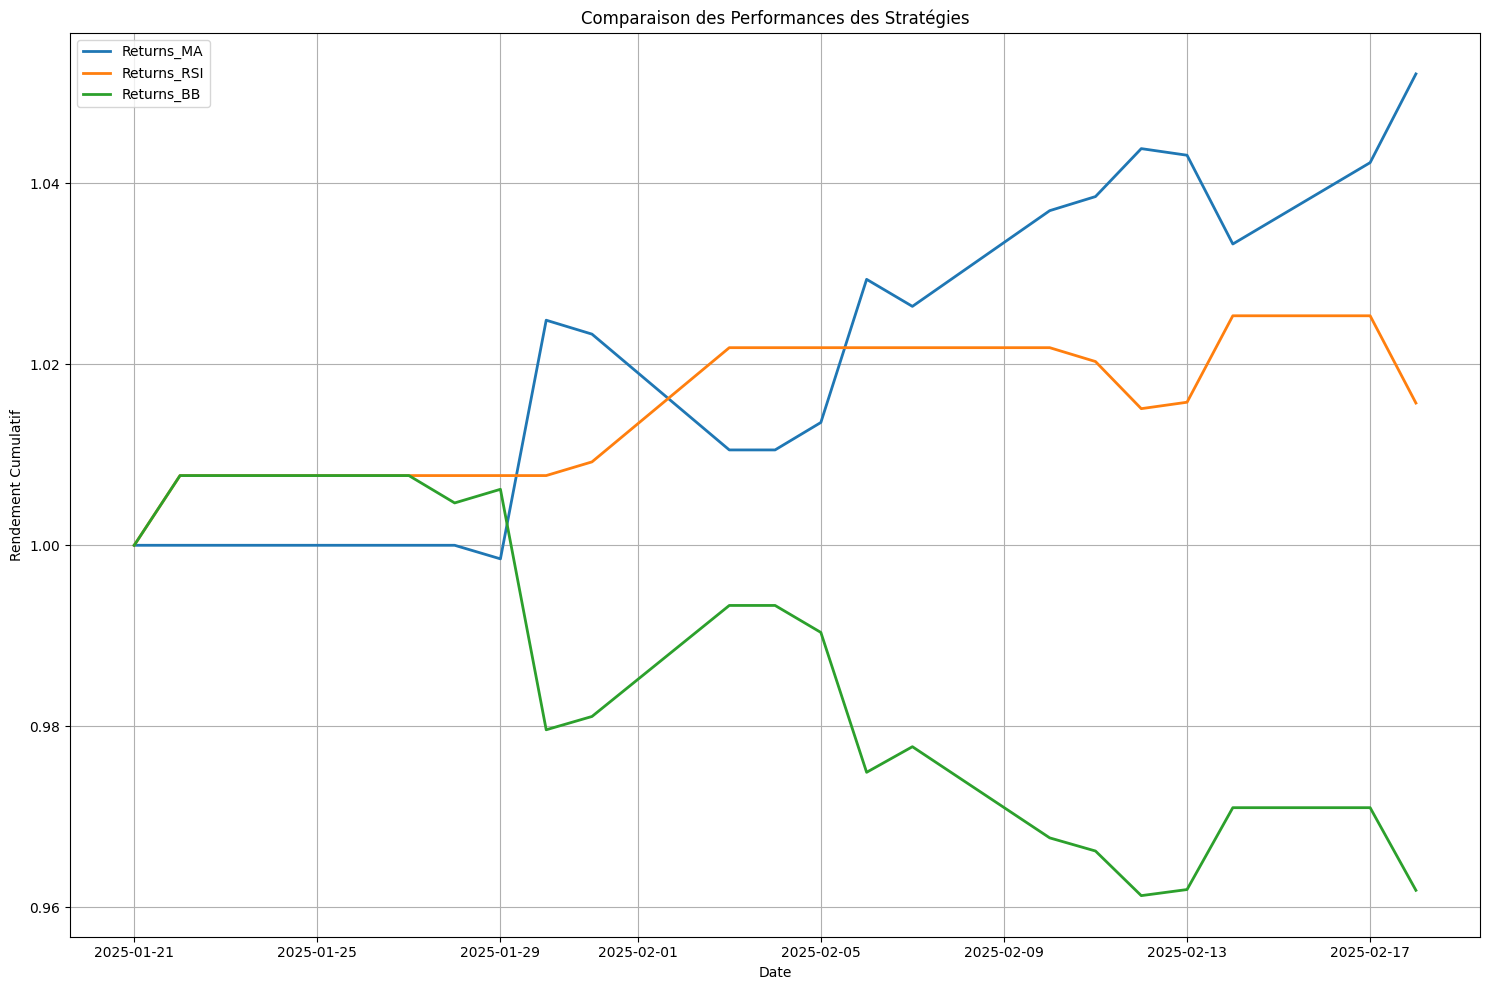

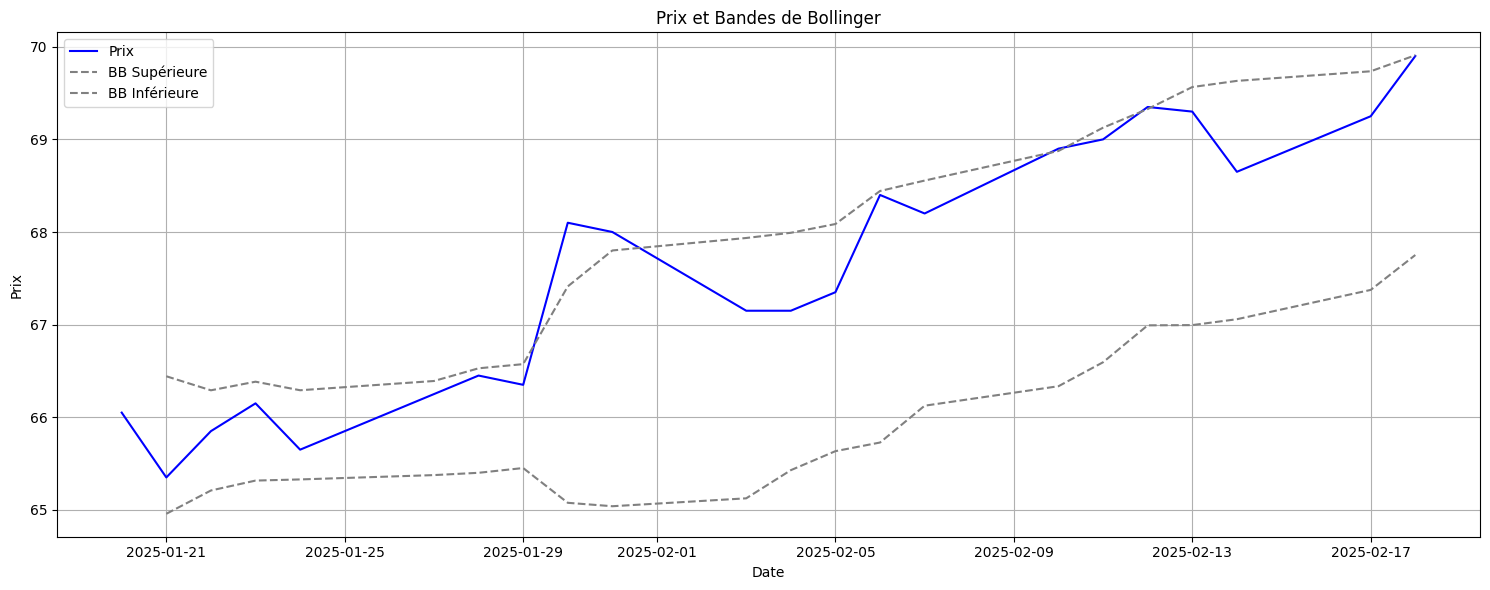


Derniers signaux générés:
Date: 2025-02-18
MA Signal: 1
RSI Signal: -1
BB Signal: -1
RSI: 74.48


In [1]:
#Importation des librairies 

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

file_path = pd.read_csv("Amundi Stock Price History.csv")

def prepare_data(file_path):
    # Lecture du fichier csv de l'action Amundi
    df = pd.read_csv(file_path)
    
    # Nettoyage des noms de colonnes 
    df.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
    
    # Conversion de la colonne Date
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    
    # Nettoyage de la colonne Volume
    df['Volume'] = df['Vol.'].str.replace('K', '000').astype(float)
    
    # Nettoyage la colonne Change
    df['Change'] = df['Change %'].str.replace('%', '').astype(float) / 100
    
    # Utilisation de Price comme Close
    df['Close'] = df['Price'].astype(float)
    
    # Trie par date
    df = df.sort_values('Date').reset_index(drop=True)
    
    return df

def moving_average_strategy(df, short_window=5, long_window=20):
    # Calcule des moyennes mobiles
    df['SMA_short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    # Génération des signaux avec une zone neutre
    df['Signal_MA'] = 0
    df.loc[df['SMA_short'] > df['SMA_long'] * 1.001, 'Signal_MA'] = 1
    df.loc[df['SMA_short'] < df['SMA_long'] * 0.999, 'Signal_MA'] = -1
    
    # Calcule des rendements
    df['Returns_MA'] = df['Change'] * df['Signal_MA'].shift(1)
    df.loc[df['Signal_MA'].shift(1) == 0, 'Returns_MA'] = 0
    
    return df

def rsi_strategy(df, period=14, overbought=70, oversold=30):
    # Calcule du RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Génération des signaux
    df['Signal_RSI'] = 0
    df.loc[df['RSI'] < oversold, 'Signal_RSI'] = 1
    df.loc[df['RSI'] > overbought, 'Signal_RSI'] = -1
    
    # Calcule des rendements
    df['Returns_RSI'] = df['Change'] * df['Signal_RSI'].shift(1)
    df.loc[df['Signal_RSI'].shift(1) == 0, 'Returns_RSI'] = 0
    
    return df

def bollinger_bands_strategy(df, window=10, num_std=1.5):
    # Calculer les bandes de Bollinger
    df['BB_middle'] = df['Close'].rolling(window=window, min_periods=1).mean()
    df['BB_std'] = df['Close'].rolling(window=window, min_periods=1).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * num_std)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * num_std)
    
    # Calcule du volume moyen
    df['Volume_MA'] = df['Volume'].rolling(window=window, min_periods=1).mean()
    
    # Génération des signaux avec des conditions plus souples
    df['Signal_BB'] = 0
    
    # Signaux d'achat avec conditions assouplies
    df.loc[(df['Close'] < df['BB_lower']) | 
           (df['Close'] < df['BB_middle'] * 0.995), 'Signal_BB'] = 1
    
    # Signaux de vente avec conditions assouplies
    df.loc[(df['Close'] > df['BB_upper']) | 
           (df['Close'] > df['BB_middle'] * 1.005), 'Signal_BB'] = -1
    
    # Calcule des rendements
    df['Returns_BB'] = df['Change'] * df['Signal_BB'].shift(1)
    df.loc[df['Signal_BB'].shift(1) == 0, 'Returns_BB'] = 0
    
    return df

def calculate_performance(df, strategy_column):
    returns = df[strategy_column].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(returns) == 0 or returns.std() == 0:
        return {
            'Total Return': 0,
            'Annual Return': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0,
            'Nombre de trades': 0,
            'Win Rate': 0
        }
    
    # Calcule de la performance cumulative
    cumulative_returns = (1 + returns).cumprod()
    
    # Statistiques de performance
    total_return = cumulative_returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    
    # Calcule du Sharpe Ratio
    sharpe_ratio = 0
    if returns.std() > 0:
        sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    
    # Calcule du drawdown maximum
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Comptage du nombre de trades et calcule du win rate
    signal_column = strategy_column.replace('Returns', 'Signal')
    trades = df[df[signal_column] != 0]
    number_of_trades = len(trades)
    
    profitable_trades = len(returns[returns > 0])
    win_rate = profitable_trades / number_of_trades if number_of_trades > 0 else 0
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Nombre de trades': number_of_trades,
        'Win Rate': win_rate
    }

def main():
    try:
        # Chargement et préparation des données
        df = prepare_data("Amundi Stock Price History.csv")
        
        print(f"Période couverte: de {df['Date'].min()} à {df['Date'].max()}")
        print(f"Nombre total de jours de trading: {len(df)}")
        
        # Application des stratégies
        df = moving_average_strategy(df)
        df = rsi_strategy(df)
        df = bollinger_bands_strategy(df)
        
        # Calcule des performances
        strategies = ['Returns_MA', 'Returns_RSI', 'Returns_BB']
        results = {}
        
        for strategy in strategies:
            results[strategy] = calculate_performance(df, strategy)
        
        # Affichage des résultats détaillés
        for strategy, metrics in results.items():
            print(f"\nPerformance de la stratégie {strategy}:")
            for metric, value in metrics.items():
                if metric in ['Nombre de trades']:
                    print(f"{metric}: {int(value)}")
                elif metric in ['Sharpe Ratio']:
                    print(f"{metric}: {value:.2f}")
                else:
                    print(f"{metric}: {value:.2%}")
        
        # Visualisation des résultats  
        plt.figure(figsize=(15, 10))
        
        # Traçages des rendements cumulatifs pour chaque stratégie
        for strategy in strategies:
            cumulative_returns = (1 + df[strategy]).cumprod()
            plt.plot(df['Date'], cumulative_returns, label=strategy, linewidth=2)
        
        plt.title('Comparaison des Performances des Stratégies')
        plt.xlabel('Date')
        plt.ylabel('Rendement Cumulatif')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Graphique pour les prix et bandes de Bollinger
        plt.figure(figsize=(15, 6))
        plt.plot(df['Date'], df['Close'], label='Prix', color='blue')
        plt.plot(df['Date'], df['BB_upper'], '--', label='BB Supérieure', color='gray')
        plt.plot(df['Date'], df['BB_lower'], '--', label='BB Inférieure', color='gray')
        plt.title('Prix et Bandes de Bollinger')
        plt.xlabel('Date')
        plt.ylabel('Prix')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Affichages des derniers signaux
        print("\nDerniers signaux générés:")
        last_day = df.iloc[-1]
        print(f"Date: {last_day['Date'].strftime('%Y-%m-%d')}")
        print(f"MA Signal: {last_day['Signal_MA']}")
        print(f"RSI Signal: {last_day['Signal_RSI']}")
        print(f"BB Signal: {last_day['Signal_BB']}")
        print(f"RSI: {last_day['RSI']:.2f}")

    except Exception as e:
        print(f"Une erreur s'est produite: {str(e)}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    main()